# Running analog Hamiltonian simulation with local simulator

We recommend to test and debug an analog Hamiltonian simulation (AHS) program on the local simulator before submitting it to a QPU. In this notebook, we introduce several features of the local simulator that will be useful to streamline this testing process.

To begin, we import the necessary packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

from braket.ahs.atom_arrangement import AtomArrangement
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation
from braket.devices import LocalSimulator
from braket.ahs.driving_field import DrivingField

from ahs_utils import show_register, show_global_drive, plot_avg_density_2D

## 2D checkerboard phase 
We consider a $3\times3$ square grid with 9 atoms. As shown in [this notebook](https://github.com/amazon-braket/amazon-braket-examples/blob/main/examples/analog_hamiltonian_simulation/02_Ordered_phases_in_Rydberg_systems.ipynb), we can realize the 2D checkerboard phase via adiabatically tuning the Rabi frequency and detuning. 

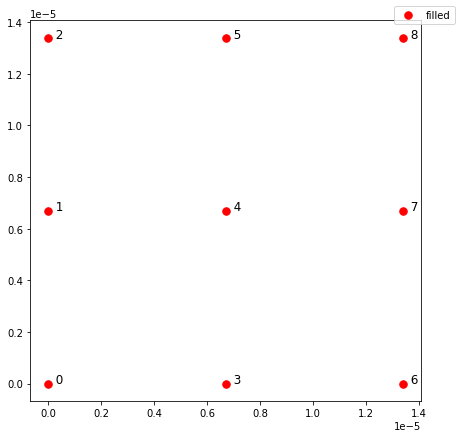

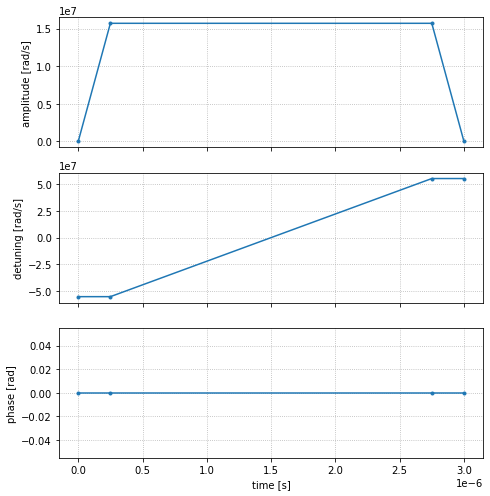

In [2]:
register = AtomArrangement()
separation = 6.7e-6  # in meters 

for k in range(3):
    for l in range(3):
        register.add((k * separation, l * separation))


time_points = [0, 2.5e-7, 2.75e-6, 3e-6]
amplitude_min = 0       # rad / s
amplitude_max = 1.57e7  # rad / s

detuning_min = -5.5e7   # rad / s
detuning_max = 5.5e7    # rad / s

amplitude_values = [amplitude_min, amplitude_max, amplitude_max, amplitude_min]  # piecewise linear
detuning_values = [detuning_min, detuning_min, detuning_max, detuning_max]  # piecewise linear
phase_values = [0, 0, 0, 0]  # piecewise constant


drive = DrivingField.from_lists(time_points, amplitude_values, detuning_values, phase_values)    
    
    
show_register(register)
show_global_drive(drive)

The AHS program can be constructed by assembling the atomic register with the driving field.

In [3]:
ahs_program = AnalogHamiltonianSimulation(
    register=register, 
    hamiltonian=drive
)

We can then run the program on the local simulator.

In [4]:
device = LocalSimulator("braket_ahs")

Below we explicitly specify `shots=1000` and `steps=100` respectively.

In [5]:
start_time = time.time()
result_full = device.run(ahs_program, shots=1000, steps=100).result()
print(f"The elapsed time = {time.time()-start_time} seconds")

The elapsed time = 12.033375024795532 seconds


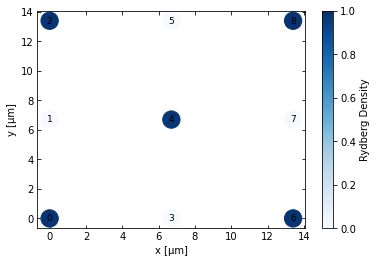

In [6]:
plot_avg_density_2D(result_full.get_avg_density(), register)

## Run AHS program in the blockade subspace

The above simulation is performed using the *full* Hamiltonian with size $2^{9}\times 2^{9}$. However, because of Rydberg blockade, if neighboring atoms are within each other's Rydberg blockade radius $R_b$, they are very unlikely to be excited to the Rydberg states simultaneously. Given that (see [this notebook](https://github.com/amazon-braket/amazon-braket-examples/blob/main/examples/analog_hamiltonian_simulation/00_Introduction_of_Analog_Hamiltonian_Simulation_with_Rydberg_Atoms.ipynb))
\begin{align}
R_b = \left[\frac{C_6}{\sqrt{\Delta^2+\Omega^2}}\right]^{1/6},
\end{align}

we have 6.752 $\mu m$ < $R_b$ < 6.796 $\mu m$ throughout the program, which is always larger than $6.7~ \mu m$, the distances between neighboring atoms. Hence we can approximate the full Hamiltonian of the system with a smaller *effective* Hamiltonian. We can take advantage of this fact to speed up the simulation by setting the parameter `blockade_radius` as shown below.

In [7]:
start_time = time.time()
result_blockade = device.run(ahs_program, shots=1000, blockade_radius=6.796e-6, steps=100).result()
print(f"The elapsed time = {time.time()-start_time} seconds")

The elapsed time = 0.434445858001709 seconds


Indeed, the runtime for the simulation with the effective Hamiltonian is one magnitude less than the one with the original Hamiltonian. We can visually confirm that the checkerboard phase is created successfully using the Rydberg blockade approximation. 

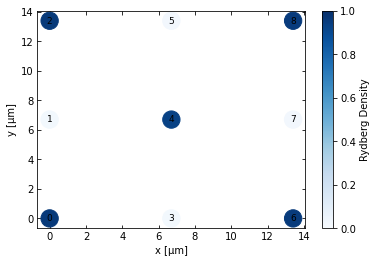

In [8]:
plot_avg_density_2D(result_blockade.get_avg_density(), register)

In order to quantify the difference in the final average Rydberg densities from the two simulations, we can calculate the root-mean-square difference (RMS) defined as 
\begin{align}
\text{RMS} = \sqrt{\frac{1}{N}\sum_{i=1}^N(\bar{n}_i^\text{full}-\bar{n}_i^\text{blockade})^2}.
\end{align}
Here $\bar{n}_i^\text{full}$ and $\bar{n}_i^\text{blockade}$ are the final Rydberg density at the $i$-th site for the simulation with the full Hamiltonian and the effective Hamiltonian respectively.

In [9]:
n_full = result_full.get_avg_density()
n_blockade = result_blockade.get_avg_density()

RMS_blockade = np.sqrt(np.mean((np.array(n_full)-np.array(n_blockade))**2))
print(f"The RMS_blockade for the final Rydberg densities = {RMS_blockade}")

The RMS_blockade for the final Rydberg densities = 0.025972207367791354


Since the RMS is only around 2%, we are assured that the simulation with the effective Hamiltonian of smaller size gives quantitatively the same results as the one with the full Hamiltonian.

## Tuning other parameters in the local simulator

Another way to speed up the simulation, without using the blockade approximation, is to adjust other parameters of the local simulator, such as `steps`, the number of time points in the simulation. Previously, we have set `steps=100`, but it can be adjusted to be `40` as shown below. We expect that the less time point used in the simulation, the faster it will finish.

In [10]:
start_time = time.time()
result_reduced_nsteps = device.run(ahs_program, shots=1000, steps=40).result()
print(f"The elapsed time = {time.time()-start_time} seconds")

The elapsed time = 5.203546047210693 seconds


This indeed speed up the simulation as expected. We can confirm that the simulation produces result that is close to our expectation. 

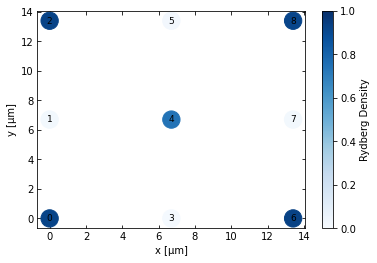

In [11]:
plot_avg_density_2D(result_reduced_nsteps.get_avg_density(), register)

In [12]:
n_reduced_nsteps = result_reduced_nsteps.get_avg_density()

RMS_reduced_nsteps = np.sqrt(np.mean((np.array(n_full)-np.array(n_reduced_nsteps))**2))
print(f"The RMS_reduced_nsteps for the final Rydberg densities = {RMS_reduced_nsteps}")

The RMS_reduced_nsteps for the final Rydberg densities = 0.08682549548759663


We note that if the Hamiltonian is almost constant throughout the AHS program, simulation with smaller `steps`, such as `80` or `50`, is likely sufficient to give qualitatively good result, as demonstrated here. On the other hand, if the Hamiltonian is varying drastically throughout the program, one may need to have higher `steps` around 200 or more.

We see that although the runtime is reduced compared to the simulation with default parameters, it is still much longer than the simulation performed with the effective Hamiltonian that uses blockade approximation. The reason is that the local simulator will need to construct Hamiltonian used for the simulation, and this takes majority part of the runtime. 

We also note that when the dimension of the Hamiltonian is larger than $2^{10}\times2^{10}$, the AHS local simulator use `scipy.integrate.ode` as the backend solver and support the following arguments: <code>atol</code>, <code>rtol</code>, <code>solver_method</code>, <code>order</code>, <code>nsteps</code>, <code>first_step</code>, <code>max_step</code> and <code>min_step</code>. For more information, please refer to the following <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.ode.html">documentation page</a>. 

When the dimension of the Hamiltonian is less than or equal to $2^{10}\times2^{10}$, we use a solver based on the <a href="https://en.wikipedia.org/wiki/Gauss%E2%80%93Legendre_method">implicit Runge-Kutta method</a> written in `numpy`, which is more efficient than the `scipy.integrate.ode` solver in this case. The solver based on `numpy` does not support the arguments listed above.